In [1]:
#!/usr/bin/python3
# -*- coding:utf-8 -*-

import itertools
import os
import pathlib
import random
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import pandas as pd
from difficulty_levels import DifficultyLevels
from tensorflow import keras
import tensorflow as tf
from typing import Optional
from tensorflow.python.keras.callbacks import ModelCheckpoint
from einops import rearrange


download_folder = "tracking_data_download"
labeled_images_folder = "labeled_images"

RANDOM_SEED = 42
NUMBER_OF_CLASSES = 3

results_folder = "ml_results"
data_folder_path = os.path.join("..", "post_processing", download_folder)
# print(data_folder_path)

NEW_IMAGE_SIZE = (128, 128)

In [2]:
def split_train_test(participant_list, train_ratio=0.8):
    random.shuffle(participant_list)

    train_split = int(len(participant_list) * train_ratio)
    train_participants = participant_list[:train_split]
    test_participants = participant_list[train_split:]
    print(f"{len(train_participants)} participants used for training: {train_participants}")
    print(f"{len(test_participants)} participants used for validation: {test_participants}")

    return train_participants, test_participants

In [3]:
def set_random_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
def show_result_plot(train_history, epochs, metric="categorical_accuracy", output_folder=results_folder,
                     output_name="train_history.png"):

    acc = train_history.history[f"{metric}"]
    val_acc = train_history.history[f"val_{metric}"]
    loss = train_history.history["loss"]
    val_loss = train_history.history["val_loss"]

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # save plot to file and show in a new window
    plt.savefig(os.path.join(output_folder, output_name))
    plt.show()

In [5]:
class DifficultyImageClassifier:
    """
    Custom CNN for predicting the difficulty level with images of a user's face.
    """

    def __init__(self, num_classes, num_epochs=32):
        self.n_classes = num_classes
        self.n_epochs = num_epochs
        self.num_workers = 8

    def build_model(self, input_shape: tuple[Optional[int], int, int, int]) -> tf.keras.Model:
        self.sequential_model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=1024, activation="relu"),
                # tf.keras.layers.Dropout(0.3),

                # units must be the number of classes -> we want a vector that looks like this: [0.2, 0.5, 0.3]
                tf.keras.layers.Dense(units=self.n_classes, activation="softmax")
            ]
        )

        self.sequential_model.summary()
        self.sequential_model.compile(optimizer="adam",
                                      loss="categorical_crossentropy",
                                      metrics=["categorical_accuracy"])

        return self.sequential_model


    def log_custom_generator_info_before(self, batch, logs):
        print("\nBefore batch: ", batch)
        print("Index list len:", len(self.train_generator.indices_list))
        print(f"get item index: {self.train_generator.get_item_index}")

    def log_custom_generator_info_after(self, batch, logs):
        print("\nAfter batch: ", batch)
        print("Index list len:", len(self.train_generator.indices_list))
        print(f"get item index: {self.train_generator.get_item_index}")

    def train_classifier(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.validation_generator = val_generator

        #self.step_size_train = train_generator.n // (train_generator.sample_size * train_generator.batch_size)
        #self.step_size_val = val_generator.n // (val_generator.sample_size * val_generator.batch_size)

        model_name = "Difficulty-CNN-Model-Generator.h5"
        model_path = os.path.join(results_folder, model_name)

        checkpoint_path = os.path.join(results_folder, "checkpoints_generator",
                                       "checkpoint-improvement-{epoch:02d}-{val_categorical_accuracy:.3f}.ckpt")
        # save checkpoints
        checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_categorical_accuracy', verbose=1,
                                              mode="max", save_best_only=True, save_weights_only=True)
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

        # define a custom callback
        custom_callback = tf.keras.callbacks.LambdaCallback(
            on_batch_begin=self.log_custom_generator_info_before, on_batch_end=self.log_custom_generator_info_after)

        history = self.sequential_model.fit(self.train_generator,
                                            #steps_per_epoch=self.step_size_train,
                                            validation_data=self.validation_generator,
                                            #validation_steps=self.step_size_val,
                                            use_multiprocessing=False,
                                            #workers=self.num_workers,
                                            max_queue_size=1,
                                            epochs=self.n_epochs,
                                            callbacks=[checkpoint_callback, lr_callback, custom_callback],
                                            verbose=1)

        # self.sequential_model.save(model_path)
        show_result_plot(history, self.n_epochs, metric="categorical_accuracy",
                         output_name="train_history_custom_generator.png")

        return history

    def evaluate_classifier(self):
        val_loss, val_acc = self.sequential_model.evaluate(self.validation_generator,
                                                           #steps=self.step_size_val,
                                                           verbose=1)
        print("Validation loss: ", val_loss)
        print("Validation accuracy: ", val_acc * 100)

In [6]:
def merge_participant_image_logs(participant_list):
    image_data_frame = pd.DataFrame()
    post_processing_folder_path = os.path.join("..", "post_processing")

    for participant in participant_list:
        images_label_log = os.path.join(post_processing_folder_path,  download_folder, participant, "labeled_images.csv")
        # images_label_log = os.path.join(post_processing_folder_path, download_folder, participant, "labeled_eye_regions.csv")
        labeled_images_df = pd.read_csv(images_label_log)

        difficulty_level_df = pd.DataFrame()
        for difficulty_level in labeled_images_df.difficulty.unique():
            # create a subset of the df that contains only the rows with this difficulty level
            sub_df = labeled_images_df[labeled_images_df.difficulty == difficulty_level]
            sub_df = sub_df[:150]
            difficulty_level_df = pd.concat([difficulty_level_df, sub_df])

        image_data_frame = pd.concat([image_data_frame, difficulty_level_df])

    # add the index numbers as own column (reset the index first as the concatenate above creates duplicate indexes)
    image_data_frame_numbered = image_data_frame.reset_index(drop=True)
    image_data_frame_numbered["index"] = image_data_frame_numbered.index

    return image_data_frame_numbered

In [7]:
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    """
    Structure based on https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    """

    def __init__(self, data_frame, x_col_name, y_col_name, sample_size, batch_size, num_classes=3,
                 images_base_path=".", use_grayscale=False):

        self.df = data_frame.copy()
        self.X_col = x_col_name
        self.y_col = y_col_name
        self.batch_size = batch_size
        self.sample_size = sample_size
        self.n_classes = num_classes
        self.images_base_path = images_base_path
        self.use_grayscale = use_grayscale

        self.n = len(self.df)
        self.get_item_index = -1

        num_channels = 1 if self.use_grayscale else 3
        self.output_size = (*NEW_IMAGE_SIZE, num_channels)

        # create a random order for the samples
        self.indices_list = self.generate_random_index_list()

    def generate_random_index_list(self):
        sample_indices = []
        for i in range(0, self.n, self.sample_size):
            sample_indices.append(i)

        random.shuffle(sample_indices)
        return sample_indices

    def __len__(self):
        length = self.n // (self.sample_size * self.batch_size)
        return length

    def on_epoch_end(self):
        self.indices_list = self.generate_random_index_list()  # each epoch we generate a new indices order
        
    def __getitem__(self, index):
        self.get_item_index = index

        X = np.empty((self.batch_size, self.sample_size, *self.output_size))
        y = np.empty((self.batch_size, self.n_classes))
        
        if len(self.indices_list) < self.batch_size:
            print(f"\nself.indices_list is empty in __get_item__()!")
            # self.indices_list = self.generate_random_index_list()

        indices = random.sample(self.indices_list, k=self.batch_size)
        
        for i, start_index in enumerate(indices):
            sample_rows = self.df[start_index:start_index + self.sample_size]
            image_sample, sample_label = self.__get_data(sample_rows)

            X[i, ] = image_sample
            y[i, ] = sample_label

        # for einops, see https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb

        reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 h (b2 w) c')
        # reshaped_X = rearrange(X, 'b1 b2 h w c -> b1 (b2 h) w c')
        print(reshaped_X.shape)

        # reshaped_y = np.repeat(y, self.sample_size, axis=0)

        # reshaped_y = np.repeat(y, self.output_size[0], axis=0)  # TODO ?
        # print(reshaped_y.shape)
        
        self.indices_list = [idx for idx in self.indices_list if idx not in set(indices)] 

        return reshaped_X, y


    def __get_data(self, sample):
        image_sample = np.empty((self.sample_size, *self.output_size))

        # Load and preprocess the images for the current sample
        i = 0
        for idx, row in sample.iterrows():
            img_path = row[self.X_col]
            image_path = os.path.join(self.images_base_path, img_path)
            image_sample[i, ] = self.__scale_and_convert_image(image_path)  # load image and resize and scale it
            i += 1

        label = sample[self.y_col].iloc[0]  # take the label of the first element in the sample
        sample_label = DifficultyLevels.get_one_hot_encoding(label)  # convert string label to one-hot-vector

        return image_sample, sample_label


    def __scale_and_convert_image(self, image_path):
        try:
            color_mode = "grayscale" if self.use_grayscale else "rgb"

            image = tf.keras.preprocessing.image.load_img(image_path, color_mode=color_mode)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            # TODO
            # image_arr = tf.image.convert_image_dtype(image_arr, tf.float32)

            # crop or pad image depending on it's size
            resized_img = tf.image.resize_with_crop_or_pad(image_arr,
                                                           target_height=NEW_IMAGE_SIZE[0],
                                                           target_width=NEW_IMAGE_SIZE[1])

            # normalize pixel values to [0, 1] so the ml model can work with smaller values
            scaled_img = resized_img.numpy() / 255.0
            return scaled_img

        except Exception as e:
            sys.stderr.write(f"\nError in processing image '{image_path}': {e}")
            return None

    def get_original_image_shape(self):
        return self.output_size
    
    def get_reshaped_image_shape(self):
        new_image_shape = ((self.sample_size * self.output_size[0]), self.output_size[1], self.output_size[2])
        return new_image_shape
    
    def get_example_batch(self):
        # we need to make a copy first so we don't actually change the list by taking an example
        indices_copy = self.indices_list.copy()
        first_sample, labels = self.__getitem__(0)
        self.indices_list = indices_copy
        return first_sample, labels

In [8]:
def show_generator_example_images(sample, labels):
    sample_len = len(sample)
    length = min(100, sample_len)  # show 100 images or sample length if samples has less images

    plt.figure(figsize=(12, 10))
    for i in range(length):
        plt.subplot(10, 10, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(sample[i])  # , cmap=plt.cm.binary)
        plt.title(DifficultyLevels.get_label_for_encoding(labels[i]))
    plt.show()

In [9]:
def show_generator_example_images_gen_v2(sample, labels):
    sample_len = len(sample)
    length = min(100, sample_len)  # show 100 images or sample length if samples has less images

    plt.figure(figsize=(40, 40))
    for i in range(length):
        plt.subplot(10, 10, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        # plt.imshow(sample[i][0:500, :, :])
        plt.imshow(sample[i][:, 0:500, :])  # if width instead of height 
        plt.title(DifficultyLevels.get_label_for_encoding(labels[i]))
    plt.show()

In [10]:
def start_preprocessing():
    set_random_seed()  # set seed for reproducibility

    """
    without_participants = ["participant_1", "participant_2", "participant_4", "participant_5", "participant_6",
                            "participant_7", "participant_8", "participant_9", "participant_11", "participant_12",
                            "participant_13"]
    """
    without_participants = []
    all_participants = os.listdir(data_folder_path)[:12]
    all_participants = [p for p in all_participants if p not in set(without_participants)]

    train_participants, test_participants = split_train_test(all_participants)

    train_data = merge_participant_image_logs(train_participants)
    val_data = merge_participant_image_logs(test_participants)

    # See https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network for consequences of
    # the batch size. Smaller batches lead to better results in general. Batch sizes are usually a power of two.
    batch_size = 3
    sample_size = 20
    train_epochs = 15
    use_gray = False
    
    print(f"Train Data len: {len(train_data)})")
    print(f"Validation Data len: {len(val_data)})")

    images_path = os.path.join("..", "post_processing")

    train_generator = CustomImageDataGenerator(data_frame=train_data, x_col_name="image_path", y_col_name="difficulty",
                                               sample_size=sample_size, batch_size=batch_size,
                                               images_base_path=images_path, use_grayscale=use_gray)

    val_generator = CustomImageDataGenerator(data_frame=val_data, x_col_name="image_path", y_col_name="difficulty",
                                             sample_size=sample_size, batch_size=batch_size,
                                             images_base_path=images_path, use_grayscale=use_gray)

    # show some example train images to verify the generator is working correctly
    sample, sample_labels = train_generator.get_example_batch()
    # show_generator_example_images(sample, sample_labels)
    show_generator_example_images_gen_v2(sample, sample_labels)

    print("Len train generator: ", train_generator.__len__())
    print("Len val generator: ", val_generator.__len__())

    image_shape = train_generator.get_original_image_shape()
    print("Image Shape: ", image_shape)
    
    reshaped_image_shape = train_generator.get_reshaped_image_shape()
    print("Reshaped Image Shape: ", reshaped_image_shape)

    classifier = DifficultyImageClassifier(num_classes=NUMBER_OF_CLASSES, num_epochs=train_epochs)

    classifier.build_model(input_shape=reshaped_image_shape)
    classifier.train_classifier(train_generator, val_generator)
    classifier.evaluate_classifier()

9 participants used for training: ['participant_3', 'participant_14', 'participant_11', 'participant_4', 'participant_5', 'participant_2', 'participant_7', 'participant_12', 'participant_13']
3 participants used for validation: ['participant_1', 'participant_10', 'participant_6']
Train Data len: 4050)
Validation Data len: 1350)
(3, 128, 2560, 3)


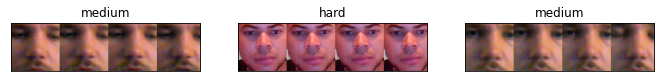

Len train generator:  67
Len val generator:  22
Image Shape:  (128, 128, 3)
Reshaped Image Shape:  (2560, 128, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2558, 126, 32)     896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1279, 63, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1277, 61, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 638, 30, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 636, 28, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 318, 14, 128)      0         
________

29/67 [===========>..................] - ETA: 2:56 - loss: 5.5311 - categorical_accuracy: 0.2989
After batch:  28
Index list len: 110
get item index: 64

Before batch:  29
Index list len: 110
get item index: 64
(3, 128, 2560, 3)
30/67 [============>.................] - ETA: 2:50 - loss: 5.4114 - categorical_accuracy: 0.2889
After batch:  29
Index list len: 107
get item index: 55

Before batch:  30
Index list len: 107
get item index: 55
(3, 128, 2560, 3)
31/67 [============>.................] - ETA: 2:44 - loss: 5.2648 - categorical_accuracy: 0.3118
After batch:  30
Index list len: 104
get item index: 5

Before batch:  31
Index list len: 104
get item index: 5
(3, 128, 2560, 3)
32/67 [=============>................] - ETA: 2:40 - loss: 5.1320 - categorical_accuracy: 0.3229
After batch:  31
Index list len: 101
get item index: 52

Before batch:  32
Index list len: 101
get item index: 52
(3, 128, 2560, 3)
33/67 [=============>................] - ETA: 2:38 - loss: 5.0106 - categorical_accura

65/67 [============================>.] - ETA: 11s - loss: 3.0850 - categorical_accuracy: 0.3231
After batch:  64
Index list len: 2
get item index: 21

Before batch:  65
Index list len: 2
get item index: 21

self.indices_list is empty in __get_item__()!
(3, 128, 2560, 3)
66/67 [============================>.] - ETA: 6s - loss: 3.0548 - categorical_accuracy: 0.3283 
After batch:  65
Index list len: 200
get item index: 7

Before batch:  66
Index list len: 200
get item index: 7
67/67 [==============================] - ETA: 0s - loss: 3.0256 - categorical_accuracy: 0.3284
After batch:  66
Index list len: 200
get item index: 7
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 25

30/67 [============>.................] - ETA: 4:34 - loss: 1.1849 - categorical_accuracy: 0.4222
After batch:  29
Index list len: 110
get item index: 8

Before batch:  30
Index list len: 110
get item index: 8
(3, 128, 2560, 3)
31/67 [============>.................] - ETA: 4:29 - loss: 1.1827 - categorical_accuracy: 0.4086
After batch:  30
Index list len: 107
get item index: 47

Before batch:  31
Index list len: 107
get item index: 47
(3, 128, 2560, 3)
32/67 [=============>................] - ETA: 4:25 - loss: 1.1799 - categorical_accuracy: 0.4167
After batch:  31
Index list len: 104
get item index: 16

Before batch:  32
Index list len: 104
get item index: 16
(3, 128, 2560, 3)
33/67 [=============>................] - ETA: 4:14 - loss: 1.1773 - categorical_accuracy: 0.4141
After batch:  32
Index list len: 101
get item index: 29

Before batch:  33
Index list len: 101
get item index: 29
(3, 128, 2560, 3)
34/67 [==============>...............] - ETA: 4:09 - loss: 1.1748 - categorical_accura

66/67 [============================>.] - ETA: 6s - loss: 1.1444 - categorical_accuracy: 0.3737 
After batch:  65
Index list len: 2
get item index: 55

Before batch:  66
Index list len: 2
get item index: 55
67/67 [==============================] - ETA: 0s - loss: 1.1437 - categorical_accuracy: 0.3682
After batch:  66
Index list len: 2
get item index: 55
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
67/67 [==============================] - 445s 6s/step - loss: 1.1437 - categorical_accuracy: 0.3682 - val_loss: 1.1207 - val_categorical_accuracy: 0.3636

Epoch 00002: val_categorical_accuracy improved from 0.28788 to 0.36364, saving model to ml_res

(3, 128, 2560, 3)
32/67 [=============>................] - ETA: 4:38 - loss: 1.1018 - categorical_accuracy: 0.3125
After batch:  31
Index list len: 104
get item index: 12

Before batch:  32
Index list len: 104
get item index: 12
(3, 128, 2560, 3)
33/67 [=============>................] - ETA: 4:32 - loss: 1.1017 - categorical_accuracy: 0.3131
After batch:  32
Index list len: 101
get item index: 31

Before batch:  33
Index list len: 101
get item index: 31
(3, 128, 2560, 3)
34/67 [==============>...............] - ETA: 4:21 - loss: 1.1013 - categorical_accuracy: 0.3235
After batch:  33
Index list len: 98
get item index: 53

Before batch:  34
Index list len: 98
get item index: 53
(3, 128, 2560, 3)
35/67 [==============>...............] - ETA: 4:10 - loss: 1.1013 - categorical_accuracy: 0.3238
After batch:  34
Index list len: 95
get item index: 13

Before batch:  35
Index list len: 95
get item index: 13
(3, 128, 2560, 3)
36/67 [===============>..............] - ETA: 4:00 - loss: 1.1012 - ca

(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
(3, 128, 2560, 3)
67/67 [==============================] - 465s 7s/step - loss: 1.0980 - categorical_accuracy: 0.2985 - val_loss: 1.4320 - val_categorical_accuracy: 0.2727

Epoch 00003: val_categorical_accuracy did not improve from 0.36364
Epoch 4/15

Before batch:  0
Index list len: 203
get item index: 18
(3, 128, 2560, 3)
(3, 128, 2560, 3)
 1/67 [..............................] - ETA: 3:51 - loss: 1.0933 - categorical_accuracy: 0.3333
After batch:  0
Index list len: 197
get item index: 0

Before batch:  1
Index list len: 197
get item index: 0
(3, 128, 2560, 3)
 2/67 [..............................] - ETA: 5:16 - loss: 1.0966 - categorical_accuracy: 0.1667
After batch:  1
Index list len: 194
get item index: 53

Before batch:  2
Index lis

34/67 [==============>...............] - ETA: 4:06 - loss: 1.1158 - categorical_accuracy: 0.3137
After batch:  33
Index list len: 98
get item index: 60

Before batch:  34
Index list len: 98
get item index: 60
(3, 128, 2560, 3)
35/67 [==============>...............] - ETA: 3:54 - loss: 1.1153 - categorical_accuracy: 0.3143
After batch:  34
Index list len: 95
get item index: 42

Before batch:  35
Index list len: 95
get item index: 42
(3, 128, 2560, 3)
36/67 [===============>..............] - ETA: 3:43 - loss: 1.1123 - categorical_accuracy: 0.3241
After batch:  35
Index list len: 92
get item index: 51

Before batch:  36
Index list len: 92
get item index: 51
(3, 128, 2560, 3)
37/67 [===============>..............] - ETA: 3:33 - loss: 1.1116 - categorical_accuracy: 0.3333
After batch:  36
Index list len: 89
get item index: 35

Before batch:  37
Index list len: 89
get item index: 35
(3, 128, 2560, 3)
38/67 [================>.............] - ETA: 3:23 - loss: 1.1116 - categorical_accuracy: 0.

Epoch 5/15

Before batch:  0
Index list len: 203
get item index: 6
(3, 128, 2560, 3)
(3, 128, 2560, 3)
 1/67 [..............................] - ETA: 4:14 - loss: 1.0149 - categorical_accuracy: 1.0000
After batch:  0
Index list len: 197
get item index: 49

Before batch:  1
Index list len: 197
get item index: 49
(3, 128, 2560, 3)
 2/67 [..............................] - ETA: 3:46 - loss: 1.0489 - categorical_accuracy: 0.8333
After batch:  1
Index list len: 194
get item index: 35

Before batch:  2
Index list len: 194
get item index: 35
(3, 128, 2560, 3)
 3/67 [>.............................] - ETA: 3:34 - loss: 1.1771 - categorical_accuracy: 0.5556
After batch:  2
Index list len: 191
get item index: 45

Before batch:  3
Index list len: 191
get item index: 45
(3, 128, 2560, 3)
 4/67 [>.............................] - ETA: 3:25 - loss: 1.1744 - categorical_accuracy: 0.5000
After batch:  3
Index list len: 188
get item index: 59

Before batch:  4
Index list len: 188
get item index: 59
(3, 128

(3, 128, 2560, 3)
37/67 [===============>..............] - ETA: 2:10 - loss: 1.0635 - categorical_accuracy: 0.3423
After batch:  36
Index list len: 89
get item index: 25

Before batch:  37
Index list len: 89
get item index: 25
(3, 128, 2560, 3)
38/67 [================>.............] - ETA: 2:06 - loss: 1.0644 - categorical_accuracy: 0.3421
After batch:  37
Index list len: 86
get item index: 64

Before batch:  38
Index list len: 86
get item index: 64
(3, 128, 2560, 3)
39/67 [================>.............] - ETA: 2:00 - loss: 1.0651 - categorical_accuracy: 0.3419
After batch:  38
Index list len: 83
get item index: 58

Before batch:  39
Index list len: 83
get item index: 58
(3, 128, 2560, 3)
40/67 [================>.............] - ETA: 1:56 - loss: 1.0642 - categorical_accuracy: 0.3417
After batch:  39
Index list len: 80
get item index: 4

Before batch:  40
Index list len: 80
get item index: 4
(3, 128, 2560, 3)
41/67 [=================>............] - ETA: 1:51 - loss: 1.0804 - categori

 3/67 [>.............................] - ETA: 14:47 - loss: 1.0780 - categorical_accuracy: 0.3333
After batch:  2
Index list len: 191
get item index: 61

Before batch:  3
Index list len: 191
get item index: 61
(3, 128, 2560, 3)
 4/67 [>.............................] - ETA: 13:53 - loss: 1.0817 - categorical_accuracy: 0.2500
After batch:  3
Index list len: 188
get item index: 47

Before batch:  4
Index list len: 188
get item index: 47
(3, 128, 2560, 3)
 5/67 [=>............................] - ETA: 12:58 - loss: 1.1033 - categorical_accuracy: 0.3333
After batch:  4
Index list len: 185
get item index: 60

Before batch:  5
Index list len: 185
get item index: 60
(3, 128, 2560, 3)
 6/67 [=>............................] - ETA: 11:34 - loss: 1.0762 - categorical_accuracy: 0.3889
After batch:  5
Index list len: 182
get item index: 44

Before batch:  6
Index list len: 182
get item index: 44
(3, 128, 2560, 3)
 7/67 [==>...........................] - ETA: 10:04 - loss: 1.3134 - categorical_accurac

(3, 128, 2560, 3)
39/67 [================>.............] - ETA: 2:13 - loss: 1.1275 - categorical_accuracy: 0.3419
After batch:  38
Index list len: 83
get item index: 42

Before batch:  39
Index list len: 83
get item index: 42
(3, 128, 2560, 3)
40/67 [================>.............] - ETA: 2:07 - loss: 1.1273 - categorical_accuracy: 0.3417
After batch:  39
Index list len: 80
get item index: 66

Before batch:  40
Index list len: 80
get item index: 66
(3, 128, 2560, 3)
41/67 [=================>............] - ETA: 2:01 - loss: 1.1266 - categorical_accuracy: 0.3415
After batch:  40
Index list len: 77
get item index: 1

Before batch:  41
Index list len: 77
get item index: 1
(3, 128, 2560, 3)
42/67 [=================>............] - ETA: 1:56 - loss: 1.1255 - categorical_accuracy: 0.3333
After batch:  41
Index list len: 74
get item index: 56

Before batch:  42
Index list len: 74
get item index: 56
(3, 128, 2560, 3)
43/67 [==================>...........] - ETA: 1:50 - loss: 1.1177 - categori

 5/67 [=>............................] - ETA: 3:31 - loss: 1.0821 - categorical_accuracy: 0.3333
After batch:  4
Index list len: 185
get item index: 3

Before batch:  5
Index list len: 185
get item index: 3
(3, 128, 2560, 3)
 6/67 [=>............................] - ETA: 3:29 - loss: 1.0847 - categorical_accuracy: 0.3333
After batch:  5
Index list len: 182
get item index: 18

Before batch:  6
Index list len: 182
get item index: 18
(3, 128, 2560, 3)
 7/67 [==>...........................] - ETA: 3:26 - loss: 1.0861 - categorical_accuracy: 0.3810
After batch:  6
Index list len: 179
get item index: 42

Before batch:  7
Index list len: 179
get item index: 42
(3, 128, 2560, 3)
 8/67 [==>...........................] - ETA: 3:21 - loss: 1.0871 - categorical_accuracy: 0.4167
After batch:  7
Index list len: 176
get item index: 14

Before batch:  8
Index list len: 176
get item index: 14
(3, 128, 2560, 3)
 9/67 [===>..........................] - ETA: 3:16 - loss: 1.0791 - categorical_accuracy: 0.44

41/67 [=================>............] - ETA: 1:24 - loss: 1.0629 - categorical_accuracy: 0.3821
After batch:  40
Index list len: 77
get item index: 9

Before batch:  41
Index list len: 77
get item index: 9
(3, 128, 2560, 3)
42/67 [=================>............] - ETA: 1:21 - loss: 1.0645 - categorical_accuracy: 0.3810
After batch:  41
Index list len: 74
get item index: 39

Before batch:  42
Index list len: 74
get item index: 39
(3, 128, 2560, 3)
43/67 [==================>...........] - ETA: 1:18 - loss: 1.0617 - categorical_accuracy: 0.3798
After batch:  42
Index list len: 71
get item index: 58

Before batch:  43
Index list len: 71
get item index: 58
(3, 128, 2560, 3)
44/67 [==================>...........] - ETA: 1:14 - loss: 1.0625 - categorical_accuracy: 0.3864
After batch:  43
Index list len: 68
get item index: 46

Before batch:  44
Index list len: 68
get item index: 46
(3, 128, 2560, 3)
45/67 [===================>..........] - ETA: 1:11 - loss: 1.0632 - categorical_accuracy: 0.39

(3, 128, 2560, 3)
 8/67 [==>...........................] - ETA: 3:02 - loss: 1.0616 - categorical_accuracy: 0.4167
After batch:  7
Index list len: 176
get item index: 55

Before batch:  8
Index list len: 176
get item index: 55
(3, 128, 2560, 3)
 9/67 [===>..........................] - ETA: 2:56 - loss: 1.0992 - categorical_accuracy: 0.3704
After batch:  8
Index list len: 173
get item index: 18

Before batch:  9
Index list len: 173
get item index: 18
(3, 128, 2560, 3)
10/67 [===>..........................] - ETA: 2:55 - loss: 1.0615 - categorical_accuracy: 0.4000
After batch:  9
Index list len: 170
get item index: 31

Before batch:  10
Index list len: 170
get item index: 31
(3, 128, 2560, 3)
11/67 [===>..........................] - ETA: 2:52 - loss: 1.0644 - categorical_accuracy: 0.4242
After batch:  10
Index list len: 167
get item index: 12

Before batch:  11
Index list len: 167
get item index: 12
(3, 128, 2560, 3)
12/67 [====>.........................] - ETA: 2:48 - loss: 1.0347 - cat

(3, 128, 2560, 3)
44/67 [==================>...........] - ETA: 1:10 - loss: 1.0211 - categorical_accuracy: 0.3788
After batch:  43
Index list len: 68
get item index: 42

Before batch:  44
Index list len: 68
get item index: 42
(3, 128, 2560, 3)
45/67 [===================>..........] - ETA: 1:07 - loss: 1.0235 - categorical_accuracy: 0.3778
After batch:  44
Index list len: 65
get item index: 41

Before batch:  45
Index list len: 65
get item index: 41
(3, 128, 2560, 3)
46/67 [===================>..........] - ETA: 1:04 - loss: 1.0174 - categorical_accuracy: 0.3841
After batch:  45
Index list len: 62
get item index: 13

Before batch:  46
Index list len: 62
get item index: 13
(3, 128, 2560, 3)
47/67 [====================>.........] - ETA: 1:01 - loss: 1.0172 - categorical_accuracy: 0.3901
After batch:  46
Index list len: 59
get item index: 57

Before batch:  47
Index list len: 59
get item index: 57
(3, 128, 2560, 3)
48/67 [====================>.........] - ETA: 58s - loss: 1.0172 - categor

10/67 [===>..........................] - ETA: 2:48 - loss: 0.9993 - categorical_accuracy: 0.3333
After batch:  9
Index list len: 170
get item index: 31

Before batch:  10
Index list len: 170
get item index: 31
(3, 128, 2560, 3)
11/67 [===>..........................] - ETA: 2:45 - loss: 0.9914 - categorical_accuracy: 0.3333
After batch:  10
Index list len: 167
get item index: 62

Before batch:  11
Index list len: 167
get item index: 62
(3, 128, 2560, 3)
12/67 [====>.........................] - ETA: 2:42 - loss: 0.9843 - categorical_accuracy: 0.3889
After batch:  11
Index list len: 164
get item index: 56

Before batch:  12
Index list len: 164
get item index: 56
(3, 128, 2560, 3)
13/67 [====>.........................] - ETA: 2:42 - loss: 1.0022 - categorical_accuracy: 0.3590
After batch:  12
Index list len: 161
get item index: 44

Before batch:  13
Index list len: 161
get item index: 44
(3, 128, 2560, 3)
14/67 [=====>........................] - ETA: 2:42 - loss: 1.0080 - categorical_accur

46/67 [===================>..........] - ETA: 1:03 - loss: 1.0095 - categorical_accuracy: 0.3768
After batch:  45
Index list len: 62
get item index: 6

Before batch:  46
Index list len: 62
get item index: 6
(3, 128, 2560, 3)
47/67 [====================>.........] - ETA: 1:00 - loss: 1.0113 - categorical_accuracy: 0.3759
After batch:  46
Index list len: 59
get item index: 8

Before batch:  47
Index list len: 59
get item index: 8
(3, 128, 2560, 3)
48/67 [====================>.........] - ETA: 59s - loss: 1.0117 - categorical_accuracy: 0.3750 
After batch:  47
Index list len: 56
get item index: 49

Before batch:  48
Index list len: 56
get item index: 49
(3, 128, 2560, 3)
49/67 [====================>.........] - ETA: 58s - loss: 1.0106 - categorical_accuracy: 0.3810
After batch:  48
Index list len: 53
get item index: 24

Before batch:  49
Index list len: 53
get item index: 24
(3, 128, 2560, 3)
50/67 [=====================>........] - ETA: 56s - loss: 1.0148 - categorical_accuracy: 0.3800
A

(3, 128, 2560, 3)
13/67 [====>.........................] - ETA: 3:05 - loss: 1.0219 - categorical_accuracy: 0.4359
After batch:  12
Index list len: 161
get item index: 36

Before batch:  13
Index list len: 161
get item index: 36
(3, 128, 2560, 3)
14/67 [=====>........................] - ETA: 3:01 - loss: 1.0290 - categorical_accuracy: 0.4286
After batch:  13
Index list len: 158
get item index: 54

Before batch:  14
Index list len: 158
get item index: 54
(3, 128, 2560, 3)
15/67 [=====>........................] - ETA: 2:56 - loss: 1.0348 - categorical_accuracy: 0.4444
After batch:  14
Index list len: 155
get item index: 61

Before batch:  15
Index list len: 155
get item index: 61
(3, 128, 2560, 3)
16/67 [======>.......................] - ETA: 2:52 - loss: 1.0391 - categorical_accuracy: 0.4167
After batch:  15
Index list len: 152
get item index: 45

Before batch:  16
Index list len: 152
get item index: 45
(3, 128, 2560, 3)
17/67 [======>.......................] - ETA: 2:48 - loss: 1.0206 

(3, 128, 2560, 3)
49/67 [====================>.........] - ETA: 56s - loss: 1.0219 - categorical_accuracy: 0.4150 
After batch:  48
Index list len: 53
get item index: 48

Before batch:  49
Index list len: 53
get item index: 48
(3, 128, 2560, 3)
50/67 [=====================>........] - ETA: 53s - loss: 1.0162 - categorical_accuracy: 0.4200
After batch:  49
Index list len: 50
get item index: 5

Before batch:  50
Index list len: 50
get item index: 5
(3, 128, 2560, 3)
51/67 [=====================>........] - ETA: 50s - loss: 1.0170 - categorical_accuracy: 0.4248
After batch:  50
Index list len: 47
get item index: 62

Before batch:  51
Index list len: 47
get item index: 62
(3, 128, 2560, 3)
52/67 [======================>.......] - ETA: 47s - loss: 1.0157 - categorical_accuracy: 0.4295
After batch:  51
Index list len: 44
get item index: 2

Before batch:  52
Index list len: 44
get item index: 2
(3, 128, 2560, 3)
53/67 [======================>.......] - ETA: 44s - loss: 1.0156 - categorical_ac

15/67 [=====>........................] - ETA: 2:44 - loss: 0.9246 - categorical_accuracy: 0.5111
After batch:  14
Index list len: 155
get item index: 4

Before batch:  15
Index list len: 155
get item index: 4
(3, 128, 2560, 3)
16/67 [======>.......................] - ETA: 2:41 - loss: 0.9277 - categorical_accuracy: 0.5000
After batch:  15
Index list len: 152
get item index: 58

Before batch:  16
Index list len: 152
get item index: 58
(3, 128, 2560, 3)
17/67 [======>.......................] - ETA: 2:37 - loss: 0.9407 - categorical_accuracy: 0.4902
After batch:  16
Index list len: 149
get item index: 21

Before batch:  17
Index list len: 149
get item index: 21
(3, 128, 2560, 3)
18/67 [=======>......................] - ETA: 2:34 - loss: 0.9488 - categorical_accuracy: 0.5000
After batch:  17
Index list len: 146
get item index: 13

Before batch:  18
Index list len: 146
get item index: 13
(3, 128, 2560, 3)
19/67 [=======>......................] - ETA: 2:32 - loss: 0.9637 - categorical_accura

51/67 [=====================>........] - ETA: 52s - loss: 0.9555 - categorical_accuracy: 0.4967
After batch:  50
Index list len: 47
get item index: 24

Before batch:  51
Index list len: 47
get item index: 24
(3, 128, 2560, 3)
52/67 [======================>.......] - ETA: 49s - loss: 0.9617 - categorical_accuracy: 0.4936
After batch:  51
Index list len: 44
get item index: 52

Before batch:  52
Index list len: 44
get item index: 52
(3, 128, 2560, 3)
53/67 [======================>.......] - ETA: 46s - loss: 0.9649 - categorical_accuracy: 0.4843
After batch:  52
Index list len: 41
get item index: 47

Before batch:  53
Index list len: 41
get item index: 47
(3, 128, 2560, 3)
54/67 [=======================>......] - ETA: 42s - loss: 0.9631 - categorical_accuracy: 0.4877
After batch:  53
Index list len: 38
get item index: 38

Before batch:  54
Index list len: 38
get item index: 38
(3, 128, 2560, 3)
55/67 [=======================>......] - ETA: 39s - loss: 0.9589 - categorical_accuracy: 0.4909


(3, 128, 2560, 3)
18/67 [=======>......................] - ETA: 2:41 - loss: 0.8844 - categorical_accuracy: 0.6296
After batch:  17
Index list len: 146
get item index: 18

Before batch:  18
Index list len: 146
get item index: 18
(3, 128, 2560, 3)
19/67 [=======>......................] - ETA: 2:37 - loss: 0.8843 - categorical_accuracy: 0.6316
After batch:  18
Index list len: 143
get item index: 47

Before batch:  19
Index list len: 143
get item index: 47
(3, 128, 2560, 3)
20/67 [=======>......................] - ETA: 2:33 - loss: 0.8960 - categorical_accuracy: 0.6333
After batch:  19
Index list len: 140
get item index: 66

Before batch:  20
Index list len: 140
get item index: 66
(3, 128, 2560, 3)
21/67 [========>.....................] - ETA: 2:29 - loss: 0.8930 - categorical_accuracy: 0.6190
After batch:  20
Index list len: 137
get item index: 61

Before batch:  21
Index list len: 137
get item index: 61
(3, 128, 2560, 3)
22/67 [========>.....................] - ETA: 2:25 - loss: 0.8996 

54/67 [=======================>......] - ETA: 40s - loss: 0.9084 - categorical_accuracy: 0.6296
After batch:  53
Index list len: 38
get item index: 31

Before batch:  54
Index list len: 38
get item index: 31
(3, 128, 2560, 3)
55/67 [=======================>......] - ETA: 37s - loss: 0.9075 - categorical_accuracy: 0.6364
After batch:  54
Index list len: 35
get item index: 36

Before batch:  55
Index list len: 35
get item index: 36
(3, 128, 2560, 3)
56/67 [========================>.....] - ETA: 34s - loss: 0.9132 - categorical_accuracy: 0.6310
After batch:  55
Index list len: 32
get item index: 0

Before batch:  56
Index list len: 32
get item index: 0
(3, 128, 2560, 3)
57/67 [========================>.....] - ETA: 31s - loss: 0.9096 - categorical_accuracy: 0.6374
After batch:  56
Index list len: 29
get item index: 38

Before batch:  57
Index list len: 29
get item index: 38
(3, 128, 2560, 3)
58/67 [========================>.....] - ETA: 28s - loss: 0.9064 - categorical_accuracy: 0.6437
Af

20/67 [=======>......................] - ETA: 2:32 - loss: 0.8849 - categorical_accuracy: 0.5667
After batch:  19
Index list len: 140
get item index: 64

Before batch:  20
Index list len: 140
get item index: 64
(3, 128, 2560, 3)
21/67 [========>.....................] - ETA: 2:28 - loss: 0.8774 - categorical_accuracy: 0.5873
After batch:  20
Index list len: 137
get item index: 31

Before batch:  21
Index list len: 137
get item index: 31
(3, 128, 2560, 3)
22/67 [========>.....................] - ETA: 2:24 - loss: 0.8718 - categorical_accuracy: 0.5758
After batch:  21
Index list len: 134
get item index: 34

Before batch:  22
Index list len: 134
get item index: 34
(3, 128, 2560, 3)
23/67 [=========>....................] - ETA: 2:21 - loss: 0.8815 - categorical_accuracy: 0.5652
After batch:  22
Index list len: 131
get item index: 35

Before batch:  23
Index list len: 131
get item index: 35
(3, 128, 2560, 3)
24/67 [=========>....................] - ETA: 2:18 - loss: 0.9031 - categorical_accu

56/67 [========================>.....] - ETA: 34s - loss: 0.8364 - categorical_accuracy: 0.6488
After batch:  55
Index list len: 32
get item index: 65

Before batch:  56
Index list len: 32
get item index: 65
(3, 128, 2560, 3)
57/67 [========================>.....] - ETA: 31s - loss: 0.8300 - categorical_accuracy: 0.6550
After batch:  56
Index list len: 29
get item index: 5

Before batch:  57
Index list len: 29
get item index: 5
(3, 128, 2560, 3)
58/67 [========================>.....] - ETA: 28s - loss: 0.8295 - categorical_accuracy: 0.6552
After batch:  57
Index list len: 26
get item index: 41

Before batch:  58
Index list len: 26
get item index: 41
(3, 128, 2560, 3)
59/67 [=========================>....] - ETA: 24s - loss: 0.8288 - categorical_accuracy: 0.6554
After batch:  58
Index list len: 23
get item index: 15

Before batch:  59
Index list len: 23
get item index: 15
(3, 128, 2560, 3)
60/67 [=========================>....] - ETA: 21s - loss: 0.8318 - categorical_accuracy: 0.6500
Af

22/67 [========>.....................] - ETA: 2:12 - loss: 0.8115 - categorical_accuracy: 0.6970
After batch:  21
Index list len: 134
get item index: 10

Before batch:  22
Index list len: 134
get item index: 10
(3, 128, 2560, 3)
23/67 [=========>....................] - ETA: 2:09 - loss: 0.8072 - categorical_accuracy: 0.6957
After batch:  22
Index list len: 131
get item index: 61

Before batch:  23
Index list len: 131
get item index: 61
(3, 128, 2560, 3)
24/67 [=========>....................] - ETA: 2:06 - loss: 0.8095 - categorical_accuracy: 0.6944
After batch:  23
Index list len: 128
get item index: 50

Before batch:  24
Index list len: 128
get item index: 50
(3, 128, 2560, 3)
25/67 [==========>...................] - ETA: 2:03 - loss: 0.8075 - categorical_accuracy: 0.7067
After batch:  24
Index list len: 125
get item index: 55

Before batch:  25
Index list len: 125
get item index: 55
(3, 128, 2560, 3)
26/67 [==========>...................] - ETA: 2:00 - loss: 0.7951 - categorical_accu

58/67 [========================>.....] - ETA: 26s - loss: 0.7348 - categorical_accuracy: 0.7299
After batch:  57
Index list len: 26
get item index: 29

Before batch:  58
Index list len: 26
get item index: 29
(3, 128, 2560, 3)
59/67 [=========================>....] - ETA: 23s - loss: 0.7321 - categorical_accuracy: 0.7345
After batch:  58
Index list len: 23
get item index: 49

Before batch:  59
Index list len: 23
get item index: 49
(3, 128, 2560, 3)
60/67 [=========================>....] - ETA: 20s - loss: 0.7299 - categorical_accuracy: 0.7389
After batch:  59
Index list len: 20
get item index: 9

Before batch:  60
Index list len: 20
get item index: 9
(3, 128, 2560, 3)
61/67 [==========================>...] - ETA: 17s - loss: 0.7278 - categorical_accuracy: 0.7377
After batch:  60
Index list len: 17
get item index: 17

Before batch:  61
Index list len: 17
get item index: 17
(3, 128, 2560, 3)
62/67 [==========================>...] - ETA: 14s - loss: 0.7193 - categorical_accuracy: 0.7419
Af

24/67 [=========>....................] - ETA: 2:07 - loss: 0.7179 - categorical_accuracy: 0.7083
After batch:  23
Index list len: 128
get item index: 39

Before batch:  24
Index list len: 128
get item index: 39
(3, 128, 2560, 3)
25/67 [==========>...................] - ETA: 2:04 - loss: 0.7122 - categorical_accuracy: 0.7067
After batch:  24
Index list len: 125
get item index: 10

Before batch:  25
Index list len: 125
get item index: 10
(3, 128, 2560, 3)
26/67 [==========>...................] - ETA: 2:01 - loss: 0.7159 - categorical_accuracy: 0.7051
After batch:  25
Index list len: 122
get item index: 44

Before batch:  26
Index list len: 122
get item index: 44
(3, 128, 2560, 3)
27/67 [===========>..................] - ETA: 1:58 - loss: 0.7071 - categorical_accuracy: 0.7037
After batch:  26
Index list len: 119
get item index: 33

Before batch:  27
Index list len: 119
get item index: 33
(3, 128, 2560, 3)
28/67 [===========>..................] - ETA: 1:55 - loss: 0.7230 - categorical_accu

60/67 [=========================>....] - ETA: 20s - loss: 0.6330 - categorical_accuracy: 0.7611
After batch:  59
Index list len: 20
get item index: 15

Before batch:  60
Index list len: 20
get item index: 15
(3, 128, 2560, 3)
61/67 [==========================>...] - ETA: 17s - loss: 0.6270 - categorical_accuracy: 0.7650
After batch:  60
Index list len: 17
get item index: 4

Before batch:  61
Index list len: 17
get item index: 4
(3, 128, 2560, 3)
62/67 [==========================>...] - ETA: 14s - loss: 0.6273 - categorical_accuracy: 0.7634
After batch:  61
Index list len: 14
get item index: 58

Before batch:  62
Index list len: 14
get item index: 58
(3, 128, 2560, 3)
63/67 [===========================>..] - ETA: 11s - loss: 0.6300 - categorical_accuracy: 0.7566
After batch:  62
Index list len: 11
get item index: 53

Before batch:  63
Index list len: 11
get item index: 53
(3, 128, 2560, 3)
64/67 [===========================>..] - ETA: 8s - loss: 0.6222 - categorical_accuracy: 0.7604 
Af

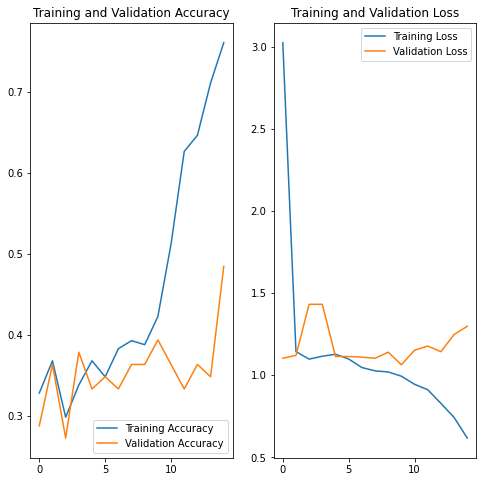

(3, 128, 2560, 3)
(3, 128, 2560, 3)
20/22 [==========================>...] - ETA: 0s - loss: 1.2555 - categorical_accuracy: 0.5000(3, 128, 2560, 3)

self.indices_list is empty in __get_item__()!
22/22 [==============================] - 7s 328ms/step - loss: 1.3117 - categorical_accuracy: 0.4545
Validation loss:  1.3117022514343262
Validation accuracy:  45.45454680919647


In [11]:
start_preprocessing()